Created on Friday 15 January 2021

**Group 5 - Clustering  
Unsupervised Clustering vf**

@authors : Theo Vedis, Jérémy Johann, Damien Izard, Nour Elhouda Kired, Paule Cadrelle Massag, Jessicka Mucy-Clavier, Gabriel nathir Kassem Rojas

The data we have studied is composed of articles, all with content, most of them with a title and tags. The aim of this group is to create clusters on these articles. 

# Pip install

In [ ]:
!pip install scikit-learn-extra

# Import libraries

In [ ]:
import os
import re
import nltk
import pickle
import string
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from tqdm import tqdm_notebook
from tqdm.notebook import tqdm
from wordcloud import WordCloud
from scipy.spatial import distance
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn_extra.cluster import KMedoids
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import calinski_harabasz_score, silhouette_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Execute this block of code only if you wish to avoid warnings in the output.
warnings.filterwarnings('ignore')
# Updating the nltk stopwords package
nltk.download('stopwords')

%matplotlib inline
%load_ext google.colab.data_table

# Create link between drive and notebook

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importation of the data sets

In [ ]:
# Data for v0
bow: pd.DataFrame = pd.read_json(
    "/content/drive/MyDrive/G5 Inter-Promo 2021/Données/Input/g3_BOW_v1.json")

In [ ]:
# Data for v1
bow_g3: pd.DataFrame = pd.read_json("/content/drive/MyDrive/G5 Inter-Promo 2021/Données/Input/g3_BOW_v1.json")

# Unwanted words that will be removed
whitelist: list = ["plus","tout","cette","ca","etre","dire","faut","fait","faire","donc","entreprise","gestion","entreprises","aussi","meme","bien","ete","comme","etat","ministre","tres","encore","peut","dont","egalement","notamment","ainsi","leurs","entre"]

# Functions used in v0 and v1 for visualization

## Word cloud

In [ ]:
# Displays a word cloud of the data in each cluster
def wordcloud_bow(bow: pd.DataFrame, prediction: list):
    """Documentation
    Parameters:
        bow: Bag of Word
        prediction: The prediction that will be used to make distinction bewteen the differents class
    """
    df: pd.DataFrame = bow.copy()
    df["pred"] = prediction

    # Distinction bewteen the differents class
    for i in set(prediction):
        wordcloud: WordCloud = WordCloud(
            relative_scaling=1.0,
        ).generate_from_frequencies(
            dict(bow.loc[df[df["pred"] == i].index].sum(axis=0))
        )
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.title("Cluster " + str(i))
        plt.show()

In [ ]:
# Displays the wordcloud for each cluster
def wordcloud_bow_v2(bow: pd.DataFrame, prediction: list, name: list = None):
    """Documentation
    Parameters:
        bow: Bag of Word
        prediction: The prediction that will be used to make distinction bewteen the differents class
        name: List of themes namess for each cluster
    """
    df: pd.DataFrame = bow.copy()
    df["pred"] = prediction

    # Distinction bewteen the differents class
    for i in set(prediction):
        wordcloud: WordCloud = WordCloud(
            relative_scaling=1.0,
        ).generate_from_frequencies(
            dict(bow.loc[df[df["pred"] == i].index].sum(axis=0))
        )
        plt.imshow(wordcloud)
        plt.axis("off")
        if name is None:
            plt.title("Cluster " + str(i))
        else:
            plt.title(name[i])
        plt.show()

## Charts

In [ ]:
# Displays data on the main components of the PCA
def graph_3d(data: pd.DataFrame, prediction: pd.Series, name: dict = None, axes: tuple = (0, 1, 2), opacity: dict = None):
    """Documentation
    Parameters:
        data : The data that will be show on the plot
        prediction : The prediction that will be used to make distinction bewteen the differents class on the plot
        name : clusters names (ex: {prediction_value: name})
        axes : Axes of pca to display points
        opacity : The transparency of the points on the graph (ex: {prediction_value: opacity_value})

    Out:
        3D graph of data on the main components of the PCA
    """

    if opacity is None:
        opacity: dict = {val: 1 for val in set(prediction)}
    if name is None:
        name: dict = {val: str(val) for val in set(prediction)}

    # Normalisation
    sc: StandardScaler = StandardScaler()
    X: np.ndarray = sc.fit_transform(data)

    # PCA
    pca: PCA = PCA(n_components=10)
    X: np.ndarray = pca.fit_transform(X)

    # Predict
    data_plot: pd.DataFrame = pd.DataFrame(X)
    data_plot["prediction"] = prediction

    # Chart
    data: list = []
    for val in set(prediction):
        data_semi_plot: pd.DataFrame = data_plot[data_plot["prediction"] == val]
        data.append(go.Scatter3d(x=data_semi_plot[axes[0]], y=data_semi_plot[axes[1]], z=data_semi_plot[axes[2]],
                                 name=name[val], mode='markers', marker=dict(size=6), opacity=opacity[val]))

    fig: go.Figure = go.Figure(data)
    fig.show()

# Method 1 (Version 0) :

**Methodology :**   
The dfFixer code compute the df_final_clean datas with the ones in Data.json in order to get 7533 lines of unique articles with their titles, tags and content.

Then, the clusterizer gets the tf-idf on our dataset and create the train and test set based on the article which have one or more tags and the ones which don't have any.

With the train set we compute a k-means model with 9 clusters. We've studied the inertia with various value of k and choose the best one. Our clustering done we compute a new tf-idf on the content of the articles contained in the train set and train a new k means model on it. Finally, we predict labels on the test set and concat all datas and predictions in the prediction dataframe.

## Functions

In [ ]:
# Cleans data
def dfFixer(pathData: str, pathDataClean: str) -> pd.DataFrame:
    """Documentation
    Parameters:
        pathData: Contains the path to our Data dataframe
        pathDataClean: Contains the path to the newer version of the dataframe

    Out:
        df_clean: Contains the cleaner dataframe with columns containing the tags and the article's title
    """
    # Step 1: load the dataframes into data and dataClean
    data: pd.DataFrame = pd.read_json(pathData)
    dataClean: pd.DataFrame = pd.read_json(pathDataClean)

    # Step 2: prepares empty lists for tags and article titles
    titles: list = ["empty"]*7533
    tags: list = [[]]*7533
    index: int = 0

    # Go through each article in dataClean and search for it's title and tags in Data.
    for i in dataClean['art_id']:
        # In case of tags, we will turn the tags into lists of tags
        titles[index] = data.loc[data['art_id'] == i]['art_title'].values[0]
        test_list: str = data.loc[data['art_id'] == i]['art_tag'].values[0]

        # Transform "None" into empty lists
        if test_list == None:
            tags[index] = []

        # Detect lists and transform them from str into lists
        elif test_list[0] == '[':
            tags[index] = eval(test_list)

        # Detects "not Found" strings and replaces them with an empty list
        else:
            if "Not Found" == test_list:
                tags[index] = []

            # Transforms any tags that are just an str into a list of 1 tag.
            else:
                tags[index] = [test_list]

        index = index+1

    # Transforms a list with empty string into an empty list
    for i in range(len(tags)):
        if tags[i] == ['']:
            tags[i] = []
        # Deletes all the hash symbols from the tags
        for j in range(len(tags[i])):
            if tags[i][j][0] == '#':
                tags[i][j] = tags[i][j][1:]

    # Step 3: prepares the output
    df_clean: pd.DataFrame = pd.DataFrame({'art_id': dataClean['art_id'],
                                           'art_content_prepd': dataClean['art_content_prepd'],
                                           'art_title': titles,
                                           'art_tag': tags})

    return df_clean

In [ ]:
def dummy(doc):
    return doc

# Find a label for each cluster (here 9 clusters)
def clusterizer(path: str) -> pd.DataFrame:
    """Documentation
    Parameters:
        path: Contains the path to our dataframe

    Out:
        df_labels: A dataframe containing a column that has the article's label
    """
    # Step 1: load the dataframe into variable df
    df: pd.DataFrame = pd.read_json(path)

    # Step 2: creates both the train set and the test set
    # Replace all the empty tags of each article with NaN value
    df.art_tag = df.art_tag.apply(lambda y: np.nan if len(y) == 0 else y)

    # Copies our dataframe as our initial train set, while dropping all the articles with no tags
    train_set: pd.DataFrame = df.copy()
    train_set.dropna(subset=['art_tag'], inplace=True)

    # Creates our test set with the articles that have no tags
    mask: pd.Series = df['art_id'].isin(train_set['art_id'])
    test_set: pd.DataFrame = df[~mask]

    # Step 3: gives all the articles in the train set labels
    stopwords_fr: list = stopwords.words('french')
    # Vectorizes all the tags in the train set while cleaning it from stop words
    vectorizer: TfidfVectorizer = TfidfVectorizer(
        tokenizer=dummy, preprocessor=dummy, stop_words=stopwords_fr)
    X = vectorizer.fit_transform(train_set['art_tag'])
    terms: list = vectorizer.get_feature_names()

    # Creates 9 clusters, each representing a label, in order to group up the tags obtained after the vectorization
    nb_clusters = 9
    kmeans: KMeans = KMeans(n_clusters=nb_clusters)

    # Creates a list containing a label for each article using the information obtained from the clusters
    ymean: np.ndarray = kmeans.fit_predict(X)

    # Stores in df the dataframe containing the articles from the train set with labels
    df_labeled: pd.DataFrame = pd.DataFrame({'art_id': train_set['art_id'],
                                             'art_content_prepd': train_set['art_content_prepd'],
                                             'art_title': train_set['art_title'],
                                             'art_tag': train_set['art_tag'],
                                             'labels': ymean})

    # Step 4: vectorizing the data in the train set to use in the test set
    ytrain: pd.Series = df_labeled['labels']
    # Redefining the vectorizer to use the content of the train_set instead
    vectorizer = TfidfVectorizer()
    vectorizer.fit(train_set['art_content_prepd'])
    vocabulary: dict = vectorizer.vocabulary_

    # Encode document
    xtrain: np.ndarray = vectorizer.transform(
        train_set['art_content_prepd']).toarray()
    xtest: np.ndarray = vectorizer.transform(
        test_set['art_content_prepd']).toarray()

    # Train our model on train_set datas
    list_classes: np.ndarray = np.arange(0, nb_clusters)
    model = KMeans(n_clusters=nb_clusters)
    clf = model.fit(xtrain, ytrain)

    # Predict
    ypred: np.ndarray = clf.predict(xtest)

    # Predict labels for test_set datas
    df_train: pd.DataFrame = pd.DataFrame({'art_id': train_set['art_id'],
                                           'labels': ymean})

    df_test: pd.DataFrame = pd.DataFrame({'art_id'	: test_set['art_id'],
                                          'labels': ypred})

    prediction_concat = pd.concat([df_train, df_test], ignore_index=True)
    prediction_sorted = prediction_concat.sort_values(['art_id', 'labels'])
    prediction_sorted.to_csv('pred_v0_clustering.csv')

    # Save our prediction in a csv file
    !cp pred_v0_clustering.csv "drive/My Drive/G5 Inter-Promo 2021/Données/Output/Clustering"

    return prediction_sorted

In [ ]:
# Drop no representative words
def whitelist_content(pd: pd.DataFrame, list_whitelist: list) -> pd.DataFrame:
    """Documentation
    Parameters:
        pd: Bag of word where we wish to drop columns of unwanted words
        list_whitelist: List of unwanted words
        
    Out:
        Bag of word without unwanted words
    """

    return pd.drop(list_whitelist, axis=1)

# Optimal number of cluster

Calculate the silhouette score and display a graph and choose the optimal number of clusters

In [ ]:
# Calculate the silhouette score
score: list = []
for i in tqdm(range(2, 21)):
    kmeans: KMeans = KMeans(i, random_state=0).fit(
        bow.drop(["art_id", "art_content_clean_without_lem"], axis=1))
    kmeans_pred: np.ndarray = kmeans.labels_
    score.append(silhouette_score(
        bow.drop(["art_id", "art_content_clean_without_lem"], axis=1), kmeans_pred))

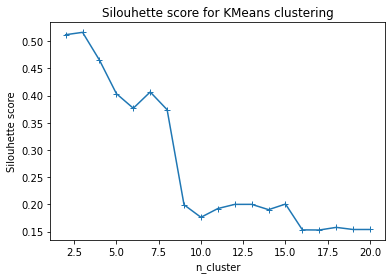

In [ ]:
# Silouhette score for kMeans clustering
plt.plot(range(2, 21), score, '-+')
plt.title("Silouhette score for KMeans clustering")
plt.xlabel("n_cluster")
plt.ylabel("Silouhette score")
plt.show()

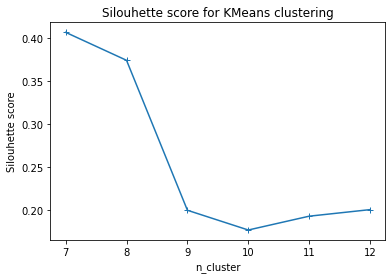

In [ ]:
# Silouhette score for kMeans clustering
window: tuple = (7, 13)
plt.plot(range(window[0], window[1]),
         score[window[0] - 2: window[1] - 2], '-+')
plt.title("Silouhette score for KMeans clustering")
plt.xlabel("n_cluster")
plt.ylabel("Silouhette score")
plt.show()

The optimal number of clusters seems to be 9 according to the silouhette score with method of KMeans.

# Prediction

In [ ]:
dataframe: pd.DataFrame = dfFixer("/content/drive/MyDrive/G5 Inter-Promo 2021/Données/Input/Data.json",
                                  "/content/drive/MyDrive/G5 Inter-Promo 2021/Données/Input/df_final_clean.json")

In [ ]:
# The path to where we wish to export our new dataframe.
path_result: str = "/content/drive/MyDrive/Colab Notebooks/test.json"

# Checks if file exist
if os.path.exists(path_result):
    os.remove(path_result)
# Exporting the dataframe to the path set in path_result in .json format
dataframe.to_json(path_result)

# Prediction des cluster
prediction: pd.DataFrame = clusterizer(path_result)
prediction

art_id  labels
5256       1       0
5257       2       0
5258      25       0
5259      27       0
5260      28       0
...      ...     ...
7528   12256       0
7529   12257       0
7530   12258       0
7531   12259       0
7532   12260       0

[7533 rows x 2 columns]

# Visualization v0

Displays wordcloud of each cluster while excluding the words in the whitelist

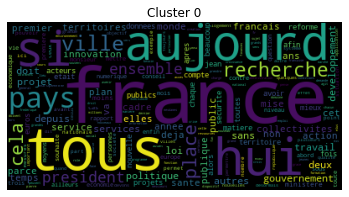

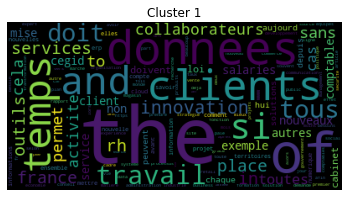

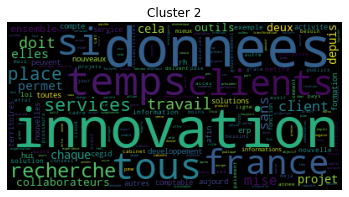

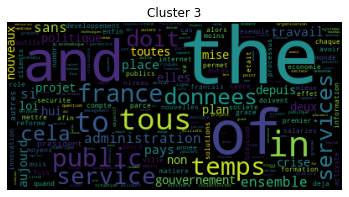

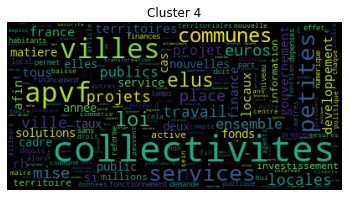

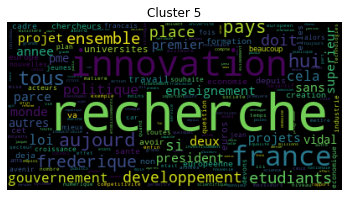

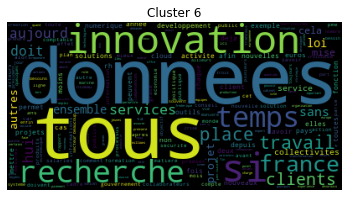

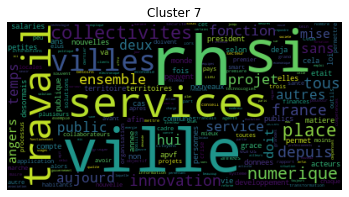

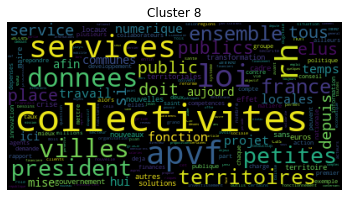

In [ ]:
# Word stop
whitelist: list = ["plus", "tout", "cette", "ca", "etre", "dire", "faut", "fait", "faire", "donc", "entreprise", "gestion", "entreprises", "aussi",
                   "meme", "bien", "ete", "comme", "etat", "ministre", "tres", "encore", "peut", "dont", "egalement", "notamment", "ainsi", "leurs", "entre"]
whitelisted_bow: pd.DataFrame = whitelist_content(
    bow.drop(["art_id", "art_content_clean_without_lem"], axis=1), whitelist)

# Word cloud
wordcloud_bow(whitelisted_bow, prediction["labels"])

Display a 3D graph of the data predicted

In [ ]:
graph_3d(bow.drop(["art_id", "art_content_clean_without_lem"], axis=1),
         prediction["labels"], opacity={i: 0.5 for i in set(prediction["labels"])})

The creation of clusters with the kmeans method does not seem suitable

# Method 2 (Version 1) :

**Methodology :**  
This code compute the dataframe containg all the article content and id and clusterizes them into an optimal number of clusters.
This number is based on the maximum value of the error based on the silhouette corresponding to the optimal value of k clusters.
Then, the program train the model on k clusters and predict labels and a title to each label.
The title is given by the nearest points of each centroids based on a metric (euclidean distance). We take the idf or bow of this articles and return the words which is as representative as possible of the cluster.

## Functions

In [ ]:
# Find the optimal number of clusters, k
def optimal_cluster(X: pd.DataFrame) -> int:
    """Documentation
    Parameters:
        X: Dataset containint all our datas we want to train the model with
        
    Out:
        Optimal value of clusters, k
    """
    list_error_silhouette: list = []
    list_k: list = []
    K: range = range(9, 26)
    sc: StandardScaler = StandardScaler()
    X: np.ndarray = sc.fit_transform(X)

    # Create the range of k which are going to be used in our loop
    for k in tqdm(K):
        pca: PCA = PCA(n_components=10, random_state=1)
        km = KMedoids(n_clusters=k, metric='cosine',  random_state=0)
        y = km.fit_predict(pca.fit_transform(X))
        list_k.append(k)
        # Create a list with all k values
        list_error_silhouette.append(silhouette_score(X, y))
        # Return the maximum of the error based on the silhouette corresponding to the optimal value of k

    plt.plot(K, list_error_silhouette)
    plt.title("Silhouette score for KMedoid clustering")
    plt.xlabel("n_cluster")
    plt.ylabel("Silhouette score")
    plt.show()

    return (list_k[np.argmax(list_error_silhouette)])

In [ ]:
# Train the chosen model on X matrix with the chosen number of clusters (nb_cluster) and return the trained model for later use
def training(X: pd.DataFrame, nb_cluster: int, path_save: str) -> (KMedoids, PCA, StandardScaler):
    """Documentation
    Parameters:
        X: The data to predict
        nb_cluster: The number of cluster
        path_save: The path to save the model
        
    Out:
        km: The model of KMedoids
        pca: The pca
        sc: The normalisation
    """
    # Nomalisation
    sc: StandardScaler = StandardScaler()
    X: np.ndarray = sc.fit_transform(X)
    pickle.dump(sc, open(path_save + "scaler_cluster.pkl", 'wb'))

    # PCA
    pca: PCA = PCA(n_components=10, random_state=1)
    X: np.ndarray = pca.fit_transform(X)
    pickle.dump(sc, open(path_save + "pca_cluster.pkl", 'wb'))

    # Kmenoids
    km: KMedoids = KMedoids(n_clusters=nb_cluster,
                            metric='cosine',  random_state=0).fit(X)
    pickle.dump(sc, open(path_save + "model_cluster.pkl", 'wb'))

    return km, pca, sc

In [ ]:
# Prepares data for a 3D graph
def prepare_graph3D(bow: pd.DataFrame) -> (pd.DataFrame, np.ndarray):
    """Documentation
    Parameters:
        bow: "bow_g3" full dataframe
        
    Out:
        X: Coordonnate for each article
        kmed_pred: KMedoids predictions
    """
    # Nomalisation
    sc: StandardScaler = StandardScaler()
    X: np.ndarray = sc.fit_transform(
        bow.drop(["art_id", "art_content_clean_without_lem"], axis=1))

    # PCA
    pca: PCA = PCA(n_components=10, random_state=1)
    X: np.ndarray = pca.fit_transform(X)

    # Kmenoids
    kmed: KMedoids = KMedoids(
        n_clusters=9, metric='cosine',  random_state=0).fit(X)
    kmed_pred: np.ndarray = kmed.predict(X)

    return X, kmed_pred

In [ ]:
# Returns the labels of the documents
def predict(X: pd.DataFrame, model: KMedoids, pca: PCA, sc: StandardScaler) -> list:
    """Documentation
    Parameters:
        X: The data to predict
        model: The model
        pca: The pca to make before to run the model
        sc: The normalisation to make before to run the pca
        
    Out:
        Return prediction
    """
    # Normalisation
    X: np.ndarray = sc.transform(X)

    # pca
    X: np.ndarray = pca.transform(X)

    # prediction
    return model.predict(X)

In [ ]:
# Calculate the chosen distance cosine between the values inside
# The cluster with label denomination and the centroid of this cluster
def compute_distance(v: np.ndarray, km: KMedoids, label: int, pca: PCA, sc: StandardScaler) -> list:
    """Documentation
    Parameters:
        v: The article to compute
        km: The model of KMedoids
        label: The number of the cluster
        pca: The pca to make before to run the model
        sc: The normalisation to make before to run the pca
        
    Out:
        Distance bewteen the point and the center of the cluster
    """

    # We make the euclidian distance between the point and the center of the cluster
    return distance.cosine(pca.transform(sc.transform(v.reshape(1, -1))), km.cluster_centers_[label])

In [ ]:
# Word creation thanks to the features of the articles
def obtain_word(list_content: list, type: str = "idf") -> str:
    """Documentation
    Parameters:
        list_content: A list of articles
        type: Type of word embedding (so "idf" for TF-IDF and "bow" for Bag-of-Word)

    Out:
        String word
    """
    # We drop english word because there is some english word in the content
    if type == "idf":
        # Vectorizes all the tags in the train set while cleaning it from stop words
        vectorizer = TfidfVectorizer(stop_words="english")
        X = vectorizer.fit_transform(list_content)
        
    # We drop english word because there is some english word in the content
    elif type == "bow":
        # Vectorizes all the tags in the train set while cleaning it from stop words
        vectorizer = CountVectorizer(stop_words="english")
        X = vectorizer.fit_transform(list_content)
        
    # Return an error while the type specified is not idf or bow
    else:
        print("None")

    # We create a dataframe with the sum of the bow/td-idf and we take the 3 word with the biggest score
    temp_data = pd.DataFrame(np.array(np.sum(X, axis=0))[0], columns=["score"])
    temp_data["word"] = vectorizer.get_feature_names()

    # Create a word column from feature integer indices to feature name
    temp_data = temp_data.sort_values(by=["score"], ascending=False)

    return temp_data.iloc[0, 1] + "/" + temp_data.iloc[1, 1] + "/" + temp_data.iloc[2, 1]

In [ ]:
# Get the contnt of an article except the words present in the whitelist
def whitelist_content(list_content: list, list_whitelist: list) -> np.ndarray:
    """Documentation
    Parameters:
        list_content: A list of articles
        list_whitelist: A whitelist of word
        
    Out:
        final_content: A list of articles without the word in the whitelist
    """
    # We create a list
    final_content: list = []

    # We take every word witch are not present in whitelist
    for content in list_content:
        temp_content = [w for w in content.split() if not w in list_whitelist]
        # We join all the word to create a sentence
        temp_content = " ".join(temp_content)
        final_content.append(temp_content)

    return np.array(final_content)

In [ ]:
# Allows you to obtain the labels for the articles
def get_label_title(data: pd.DataFrame, whitelist: list, km: KMedoids, pca: PCA, sc: StandardScaler) -> dict:
    """Documentation
    Parameters:
        data: A dataframe containing all our datas we want to work with
        whitelist: A whitelist of words we want to avoid in labels title
        km: The model of KMedoids
        pca: The pca to make before to run the model
        sc: The normalisation to make before to run the pca
        
    Out:
        themes: A string containing our title of the chosen label
    """
    # We create the dictionnary that will contain the label corresponding to each cluster
    themes: dict = {}
    
    # We create a copy of the dataframe which only contain the cluster corresponding to the value of label
    for label in np.unique(data["prediction"]):
        sub_data = data.query("prediction == @label").drop(
            ["prediction"], axis=1).copy()

        # We compute the distance bewteen the center of the cluster and all the point of the cluster
        sub_data["score"] = sub_data.drop(["art_id", "art_content_clean_without_lem"], axis=1).apply(
            compute_distance, axis=1, raw=True, args=(km, 0, pca, sc))

        # We take the five closest document of the center
        head_content = sub_data.sort_values(by=["score"], ascending=True).head(5)[
            "art_content_clean_without_lem"].values

        # We drop the word in the whitelist
        head_content = whitelist_content(head_content, whitelist)

        # We get the label of ech cluster by checking the three recurents words
        themes[label] = obtain_word(head_content, type="bow")

    return themes

In [ ]:
# Clusters the dataset with the optimal number of clusters and return
def predict_cluster(data: pd.DataFrame, path_save: str) -> pd.DataFrame:
    """Documentation
    Parameters:
        data: A dataframe containing all our datas we want to work with
        path_save: The path to save the model
        
    Out:
        A dataframe containing our id and the title of the chosen label
    """
    # We use the function higher to obtain the good number of clusters
    nb_cluster = optimal_cluster(
        data.drop(["art_id", "art_content_clean_without_lem"], axis=1))

    # nb_cluster=9
    print("We take " + str(nb_cluster) + " clusters.")

    # We train the kmenoide, pca and normalisation to make prediction
    model, pca, sc = training(data.drop(
        ["art_id", "art_content_clean_without_lem"], axis=1), nb_cluster, path_save)

    # We predict the cluster with the kmenoide, pca and normalisation trained
    data["prediction"] = predict(
        data.drop(["art_id", "art_content_clean_without_lem"], axis=1), model, pca, sc)

    # We create a whitelist to drop some recurents word that was not drop
    whitelist = ["plus", "tout", "cette", "ca", "etre",
                 "dire", "faut", "fait", "faire", "donc"]

    # We create the label of each cluster
    data["name_theme"] = data["prediction"].map(
        get_label_title(data, whitelist, model, pca, sc))

    return data[["art_id", "name_theme"]]

# Optimal number of cluster

In [ ]:
# Calculating the optimal number of clusters
nb_cluster: int = optimal_cluster(bow_g3.drop(
    ["art_id", "art_content_clean_without_lem"], axis=1))
print("We take " + str(nb_cluster) + " clusters.")

#Prediction

In [ ]:
# We take out the model because we need to save it to predict later
bow_g3_result: pd.DataFrame = bow_g3.copy()
output: pd.DataFrame = predict_cluster(
    bow_g3_result, "/content/drive/MyDrive/projetInterpromo2021/")
output.head(5)

We take 9 clusters.


art_id                     name_theme
1        1  logiciel/solutions/entreprise
2        2  logiciel/solutions/entreprise
25      25        loyer/formation/travail
27      27  logiciel/solutions/entreprise
28      28  logiciel/solutions/entreprise

In [ ]:
print("Cluster_name / Population")
pd.Series(output["name_theme"]).value_counts()

Cluster_name / Population


logiciel/solutions/entreprise       3400
loyer/formation/travail              711
donnees/erp/cloud                    710
entreprise/comptabilite/cloud        572
si/entreprise/innovation             572
cas/bien/si                          424
taux/prelevement/paie                418
cegid/loop/site                      375
numerique/territoires/communaute     351
Name: name_theme, dtype: int64

# Visualization v1

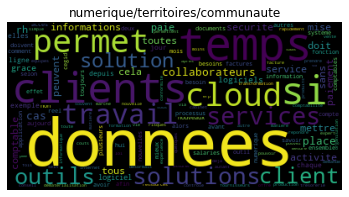

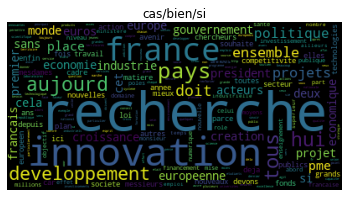

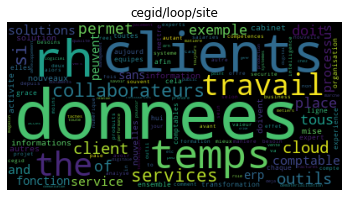

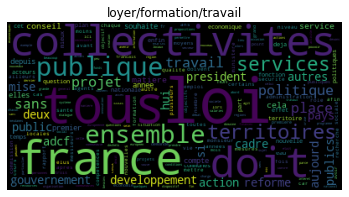

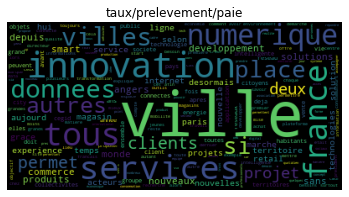

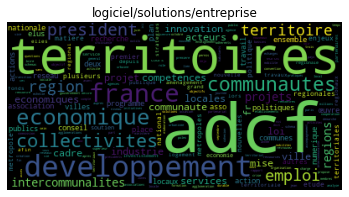

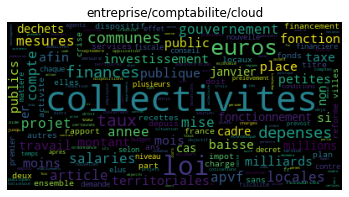

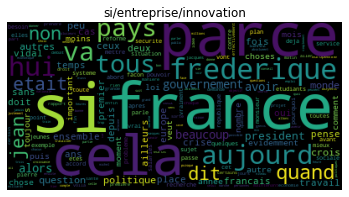

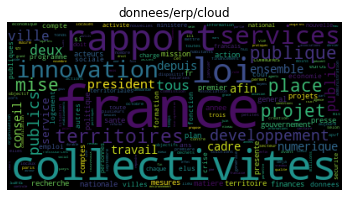

In [ ]:
wordcloud_bow_v2(bow_g3.drop(["art_id", "art_content_clean_without_lem", *whitelist], axis=1), bow_g3_result["prediction"], {
                 i: j for i, j in zip(set(bow_g3_result["prediction"]), set(bow_g3_result["name_theme"]))})

In [ ]:
# PCA + Kmeans
coord, pred = prepare_graph3D(bow_g3)
graph_3d(coord, pred)
pd.Series(pred).value_counts()

8    3400
3     711
2     710
1     573
0     570
7     424
6     419
4     376
5     350
dtype: int64

# Conclusion

In the v0 we vectorized our datas using the TF-IDF. Then, we have calculated the number of clusters with a k optimal and the optimal number of clusters seems to be 9. We have used the method KMeans but this method does not seem suitable.
In the v1 we have vectorized the bow of the group 3 and made an ACP on this data. Also, we have used the method of KMedoide with 9 clusters.
 The results are better in terms of article repartition than in the v0. The graphical representation is also mush better in terms of clustering qualities. Indeed, the clusters are more well formed in the v1.


The results are not perfect, our documents are very close to each other because they tackled about the same subjects that's why our 3D representation shows a big heap of documents and not many articles are very different of the others.

This problem is also shown in the word clouds because the most representatives words are almost always the same in each cluster.